In [30]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.random import set_seed

from tqdm import tqdm
from contextlib import redirect_stdout
import os

import utils

import math

import matplotlib.pyplot as plt
import matplotlib

In [9]:
# Define a model name for repeated use
modelNames = ["AlexNet","DenseNet121","DenseNet201","InceptionResNetV2","mAlexNet","mDenseNet","SimpleDenseNet","SimpleNet","SimpleResNet"]
n_folds = 10 # 1 = normal experiment
batch_size = 128 # 128 is default across the models

In [10]:
#Seeding random state to 13 always, for reproducibility
np.random.seed(utils.seed)
set_seed(utils.seed)

In [11]:
### Used to select GPU 0=first device, 1=second device, etc...
os.environ["CUDA_VISIBLE_DEVICES"]="1"

gpus = tf.config.experimental.list_physical_devices('GPU')
print('gpus:',gpus)
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

gpus: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPU, 1 Logical GPUs


In [12]:
dataset = utils.makeDataset(pathFromCwdToDataRoot="Data")

94493it [00:00, 981275.75it/s]
94493it [00:00, 1380569.00it/s]
31825it [00:00, 1277185.11it/s]
31825it [00:00, 1955633.57it/s]


In [13]:
kFCV_sets, weights_dict = utils.makeFolds(dataset=dataset, n_folds=n_folds, batch_size=batch_size)

Found 102315 non-validated image filenames belonging to 2 classes.
Found 12633 non-validated image filenames belonging to 2 classes.
Found 11370 non-validated image filenames belonging to 2 classes.

Found 102315 non-validated image filenames belonging to 2 classes.
Found 12633 non-validated image filenames belonging to 2 classes.
Found 11370 non-validated image filenames belonging to 2 classes.

Found 102315 non-validated image filenames belonging to 2 classes.
Found 12633 non-validated image filenames belonging to 2 classes.
Found 11370 non-validated image filenames belonging to 2 classes.

Found 102315 non-validated image filenames belonging to 2 classes.
Found 12633 non-validated image filenames belonging to 2 classes.
Found 11370 non-validated image filenames belonging to 2 classes.

Found 102315 non-validated image filenames belonging to 2 classes.
Found 12633 non-validated image filenames belonging to 2 classes.
Found 11370 non-validated image filenames belonging to 2 classes.



In [14]:
print(weights_dict)

{0: 0.9585261658953365, 1: 1.045225155279503}


In [18]:
def get_flops(model_h5_path):
    session = tf.compat.v1.Session()
    graph = tf.compat.v1.get_default_graph()


    with graph.as_default():
        with session.as_default():
            model = tf.keras.models.load_model(model_h5_path)

            run_meta = tf.compat.v1.RunMetadata()
            opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()

            # Optional: save printed results to file
            # flops_log_path = os.path.join(tempfile.gettempdir(), 'tf_flops_log.txt')
            # opts['output'] = 'file:outfile={}'.format(flops_log_path)

            # We use the Keras session graph in the call to the profiler.
            flops = tf.compat.v1.profiler.profile(graph=graph,
                                                  run_meta=run_meta, cmd='op', options=opts)

            return flops.total_float_ops

In [22]:
k = kFCV_sets[0]
train_generator, test_generator, val_generator = k

for modelName in modelNames:

    keras.backend.clear_session()
    
    model = keras.models.load_model('Models/'+modelName)

    #Test accuracy
    results = model.evaluate(
        test_generator,
        max_queue_size = os.cpu_count(),
        workers = os.cpu_count(),
    )

    accuracy = round(results[1]*100,2)

    parameters = model.count_params()

    flops = get_flops('Models/'+modelName)

    print(modelName,accuracy,parameters,flops)

99/99 [==============================] - 26s 137ms/step - loss: 0.0363 - accuracy: 0.9922
AlexNet 99.22 76053109 152052017
99/99 [==============================] - 28s 143ms/step - loss: 0.0278 - accuracy: 0.9922
DenseNet121 99.22 9151425 18302944
99/99 [==============================] - 31s 165ms/step - loss: 0.0433 - accuracy: 0.9869
DenseNet201 98.69 18584513 37169520
99/99 [==============================] - 34s 180ms/step - loss: 6.9103 - accuracy: 0.9333
InceptionResNetV2 93.33 56122977 112215528
99/99 [==============================] - 26s 142ms/step - loss: 0.8143 - accuracy: 0.9280
mAlexNet 92.8 21195 42166
99/99 [==============================] - 26s 143ms/step - loss: 0.1749 - accuracy: 0.9721
mDenseNet 97.21 11009 21458
99/99 [==============================] - 27s 146ms/step - loss: 0.2946 - accuracy: 0.9596
SimpleDenseNet 95.96 361729 715746
99/99 [==============================] - 27s 147ms/step - loss: 0.5420 - accuracy: 0.8885
SimpleNet 88.85 6017 11780
99/99 [==========

In [203]:
#Copied from results table

Networks=pd.DataFrame({
    "Network":["AlexNet","InceptionResNetV2","DenseNet201","DenseNet121","SimpleDenseNet","SimpleResNet","mAlexNet","mDenseNet","SimpleNet"],
    "Accuracy":[99.09, 95.40, 99.16, 98.90, 95.89, 86.95, 93.80, 96.35, 89.52],
    "KParameters":[76053109/10**3, 56122977/10**3, 18584513/10**3, 9151425/10**3, 361729/10**3, 352513/10**3, 21195/10**3, 11009/10**3, 6017/10**3],
    "MFLOPs":[152052017/10**6, 56122977/10**6, 37169520/10**6, 18302944/10**6, 715746/10**6, 702668/10**6, 42166/10**6, 21458/10**6, 11780/10**6],
})

In [190]:
#  0:'red', 1:'blue', 2:'green', 3:'black', 4:'orange', 5:'purple',
#  6:'magenta', 7:'brown', 8:'cyan', 9:'limegreen'

colors=['red', 'blue', 'green', 'orange', 'purple',
        'magenta', 'brown', 'cyan', 'limegreen']
cmap=matplotlib.colors.ListedColormap(colors)

In [ ]:
colors2=['gray', 'gray', 'gray', 'gray', 'gray',
        'gray', 'gray', 'gray', 'gray']
cmap2=matplotlib.colors.ListedColormap(colors2)

fig, ax = plt.subplots(figsize=(6,6))
scatter = ax.scatter([0,0,0],[0,0,0],c=range(3), cmap=cmap2, s=(np.array([10,1000,10000])**.35)*50/2,)

handles2, labels2 = scatter.legend_elements(prop="sizes", alpha=0.6)[0],['10K','100K','10M']
legend2 = ax.legend(handles2, labels2, loc="lower right", title="Sizes",prop={'size': 10,})

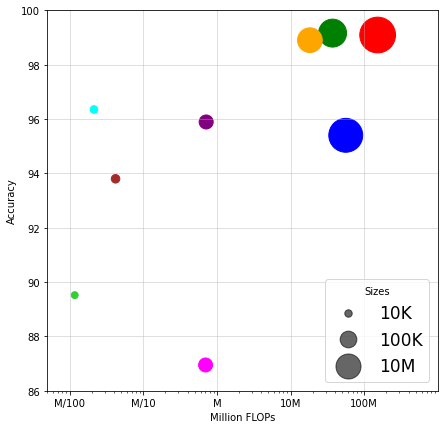

In [205]:

fig, ax = plt.subplots(figsize=(7,7))
scatter = ax.scatter(Networks["MFLOPs"],Networks["Accuracy"],c=range(9), cmap=cmap, s=(Networks["KParameters"]**.35)*50/2,)

# for i, txt in enumerate(Networks["Network"]):
#     ax.annotate(txt, (Networks["MFLOPs"][i], Networks["Accuracy"][i]))

ax.grid(b=None, which='major', axis='both', alpha=0.5)

ax.set_ylabel("Accuracy")
ax.set_ylim(86, 100)

ax.set_xlabel("Million FLOPs")
ax.set_xscale("log")
ax.set_xlim(0.005, 1000)
ax.set_xticks([0.01, 0.1, 1, 10, 100])

labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = 'M/100'
labels[1] = 'M/10'
labels[2] = 'M'
labels[3] = '10M'
labels[4] = '100M'

ax.set_xticklabels(labels)

#handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
legend2 = ax.legend(handles2, labels2, loc="lower right", title="Sizes",prop={'size': 17})